# Load Results

In [2]:
# to reload local packages when debugging
%load_ext autoreload
%autoreload 2

%cd /mnt/c/Users/resha/Documents/Github/balancing_framework/

import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric(result_sets, metric, focused_form, title):
    plt.figure(figsize=(6, 4))  
    df = pd.DataFrame()

    for result_set_data_form, result_set_data in result_sets.items():
        means1 = np.array([ x[f'{metric}_mean'] for x in result_set_data ])
        # std1 = np.array([ x[f'{metric}_std'] for x in result_set_data ])
        timestamps1 = np.array([ x['last_ts'] for x in result_set_data ])

        # print(set_form_title)
        # print(f'Average Value: {np.mean(means1):.5g}, Highest Value: {np.max(means1):.5g}, Lowest Value: {np.min(means1):.5g}')
        df = pd.concat([df, pd.DataFrame({'mean_acc': np.mean(means1), 'low_acc': np.min(means1), 'high_acc': np.max(means1)}, index=[result_set_data_form])], axis=0)

        if result_set_data_form == focused_form:
            sns.lineplot(x=timestamps1, y=means1, label=result_set_data_form, linewidth=2)
        else:
            sns.lineplot(x=timestamps1, y=means1, label=result_set_data_form, linewidth=0.5)
        
        # plt.fill_between(timestamps1, means1 - std1, means1 + std1, alpha=0.3, label=f'{result_set_data_form} Std Dev')

    plt.title(title) #(f'{title}: {metric}')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{metric}')
    plt.legend()

    plt.tight_layout()  # adjust the layout to fit the figure size
    # plt.show()
    
    df = df.reset_index().rename(columns={'index': 'data_form'})
    return df, plt


/mnt/c/Users/resha/Documents/Github/balancing_framework


In [3]:

import os
# datasets = ['electricity', 'm4_daily_dataset', 'm4_daily_dataset_gluonts',  'london_smart_meters_without_missing', 'weather_dataset']
datasets = ['m4_daily_dataset']

def load_results(datasets):
    
    ar_res = {}
    cr_res = {}
    # for dataset in os.listdir('/mnt/c/Users/resha/Documents/Github/balancing_framework/results/monash_picked_single_series_runs'):
    for dataset in datasets:
        res_dir = f'/mnt/c/Users/resha/Documents/Github/balancing_framework/results/monash_picked_single_series_runs/{dataset}'
        ar_res[dataset] = {}
        cr_res[dataset] = {}
        for dir in os.listdir(res_dir):
            if '.' in dir:
                continue

            series_num = dir.split('[')[0].split('_')[-2]
            if series_num not in ar_res[dataset].keys():
                ar_res[dataset][series_num] = {}
                cr_res[dataset][series_num] = {}

            forms_string = dir.split(']')[0].split('[')[1]
            # map form strings to print friendly
            type_map = {"'o'": 'original', "'fd'": 'frac_diff', "'fod'": 'first_order_diff',
                        "'tao'": 'original_ta', "'tafd'": 'frac_diff_ta', "'tafod'": 'first_order_diff_ta',}
            forms_string = ' + '.join([type_map[abbr] for abbr in forms_string.replace(" ", "").split(",")])

            with open(f'{res_dir}/{dir}/adaptation_results.pkl', 'rb') as f:
                ar = pickle.load(f)
            with open(f'{res_dir}/{dir}/consolidation_results.pkl', 'rb') as f:
                cr = pickle.load(f)

            # ar_res[dataset][series_num].append((forms_string, ar))
            # cr_res[dataset][series_num].append((forms_string, cr))
            ar_res[dataset][series_num][forms_string] = ar
            cr_res[dataset][series_num][forms_string] = cr
    return ar_res, cr_res


# Plots

In [4]:

def plot_res_build_resdf(ar_res, cr_res, metric='accuracy'):
    results = pd.DataFrame()
    base_dir = f'/mnt/c/Users/resha/Documents/Github/balancing_framework/results/monash_picked_single_series_runs/'
    focused_form = 'original + frac_diff'

    for key, value in ar_res.items(): # item = dataset_name, series dict
        dataset = key
        res_dir = f'{base_dir}/{dataset}'
        for key, value in value.items(): # item = series_num, list of results pulled
            series_num = key
            df, plt = plot_metric(value, metric, focused_form, f'Comparison of Adaptation {metric} for {dataset}_{series_num}')
            df['dataset'] = dataset
            df['value_type'] = 'adaptation'
            df['series_num'] = series_num
            results = pd.concat([results, df], ignore_index=True)
            plt.savefig(f'{res_dir}/ada_comp_{metric}_{series_num}.png')
    for key, value in cr_res.items(): # item = dataset_name, series dict
        dataset = key
        for key, value in value.items(): # item = series_num, list of results pulled
            series_num = key
            df, plt = plot_metric(value, metric, focused_form, f'Comparison of Consolidation {metric} for {dataset}_{series_num}')
            df['dataset'] = dataset
            df['value_type'] = 'consolidation'
            df['series_num'] = series_num
            results = pd.concat([results, df], ignore_index=True)
            plt.savefig(f'{res_dir}/cons_comp_{metric}_{series_num}.png')

    return results

# Stability Estimate

In [5]:
import itertools
def append_stab(res_pack, results, value_type, metric='accuracy'):
    metric_key = f'{metric}_mean'
    form_keys = ['original', 'frac_diff', 'first_order_diff', 'original_ta', 'frac_diff_ta', 'first_order_diff_ta'] # individual forms
    form_keys = [' + '.join(combo) 
        for r in range(1, len(form_keys) + 1) 
        for combo in itertools.combinations(form_keys, r)
    ] # all combinations of the forms
    
    for dataset in res_pack.keys():
        for series_num in res_pack[dataset].keys():
            for form in form_keys:
                if form in res_pack[dataset][series_num].keys():
                    metric_vals = [ res[metric_key] for res in res_pack[dataset][series_num][form] ]
                    var = np.var(metric_vals)
                    mean = np.mean(metric_vals)
                    coeff_var = (np.std(metric_vals) / np.mean(metric_vals)) * 100
                    # append the values to the passed results df
                    idx = results.loc[results['dataset'] == dataset].loc[ results['value_type'] == value_type].loc[results['series_num'] == series_num].loc[results['data_form'] == form].index
                    results.loc[idx, 'stab_var'] = var
                    results.loc[idx, 'stab_mean'] = mean
                    results.loc[idx, 'stab_coeff_var'] = coeff_var
    return results

# Run

In [8]:
ar_res['sp500_run5']['1']['original + frac_diff']

[{'accuracy_mean': nan,
  'f1_mean': nan,
  'accuracy_std': nan,
  'f1_std': nan,
  'mape_mean': 0.5186467811280034,
  'mape_std': 0.0,
  'rmse_mean': 53.92556198463675,
  'rmse_std': 0.0,
  'mase_mean': 135.56623598285762,
  'mase_std': 0.0,
  'smape_mean': 0.7009269136237564,
  'smape_std': 0.0,
  'time_training_seconds': 3.6900671829999965,
  'time_test_seconds': nan,
  'model_name': 'transformer',
  'last_ts': Timestamp('2003-10-22 19:50:00-0400', tz='America/New_York')}]

,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,original + frac_diff,135.566236,135.566236,135.566236,sp500_run5,adaptation,1,0.000000,135.566236,0.000000
1,original,1.444351,0.180644,3.860401,sp500_run5,adaptation,1,1.642339,1.444351,88.727611
2,original + frac_diff,128.997573,128.997573,128.997573,sp500_run5,consolidation,1,0.000000,128.997573,0.000000
3,original,1.482008,0.215296,3.549740,sp500_run5,consolidation,1,1.415366,1.482008,80.275649


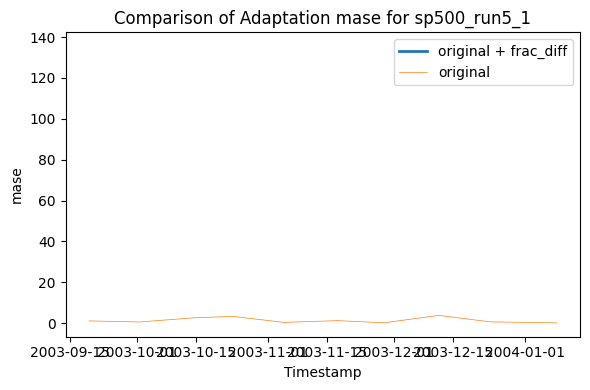

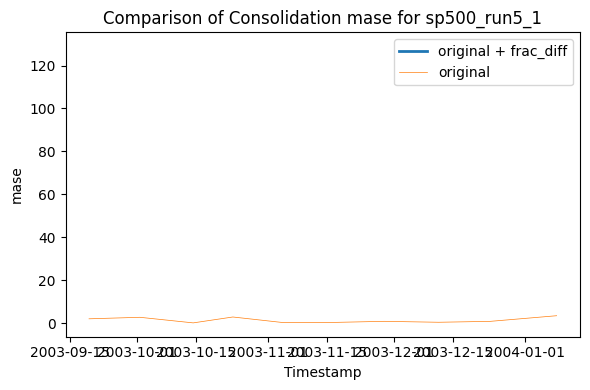

In [6]:
datasets = ['sp500_run5']

ar_res, cr_res = load_results(datasets)
results = plot_res_build_resdf(ar_res, cr_res, metric='mase')

results = append_stab(ar_res, results, 'adaptation', metric='mase')
results = append_stab(cr_res, results, 'consolidation', metric='mase')
results

,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,original + frac_diff + first_order_diff,94.6666666667,90.4301075269,100.0000000000,m4_daily_dataset,adaptation,1165,0.0008514742,0.9466666667,3.0823975498
1,original + frac_diff,95.6983527797,90.0000000000,98.2258064516,m4_daily_dataset,adaptation,1165,0.0004877468,0.9569835278,2.3077711709
2,original + first_order_diff,47.8970977547,40.3225806452,52.9787234043,m4_daily_dataset,adaptation,1165,0.0013108035,0.4789709775,7.5589173893
3,original,53.6131912442,44.5161290323,65.8064516129,m4_daily_dataset,adaptation,1165,0.0034421959,0.5361319124,10.9432451870
4,frac_diff,67.0098073836,53.2900000000,85.4700000000,sp500_run1,adaptation,1,0.0035048291,0.6700980738,8.8347659943
5,first_order_diff,57.0896802667,47.4900000000,73.8600000000,sp500_run1,adaptation,1,0.0026607460,0.5708968027,9.0353315747
6,original,68.9449915346,56.1100000000,85.9900000000,sp500_run1,adaptation,1,0.0039872126,0.6894499153,9.1586607289
7,original + frac_diff + first_order_diff,79.0216349461,66.7300000000,92.8000000000,sp500_run3,adaptation,1,0.0032468625,0.7902163495,7.2108413191
8,original + frac_diff,82.2602453566,73.7100000000,93.7700000000,sp500_run3,adaptation,1,0.0021252652,0.8226024536,5.6042379314
9,original + first_order_diff,67.9899716692,55.6900000000,85.2600000000,sp500_run3,adaptation,1,0.0039227439,0.6798997167,9.2119191721


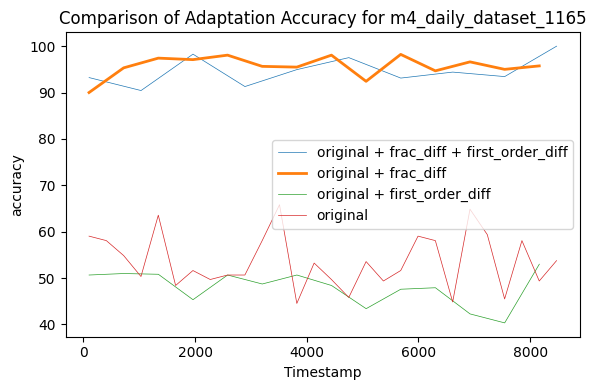

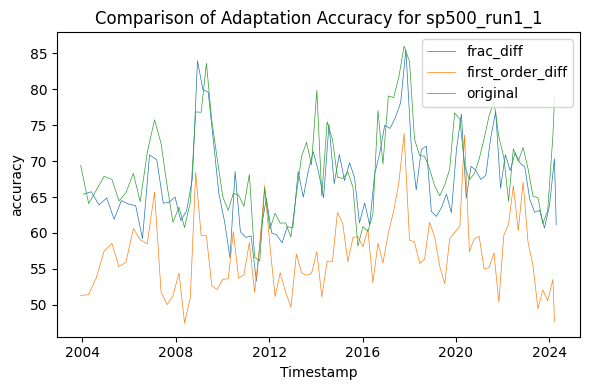

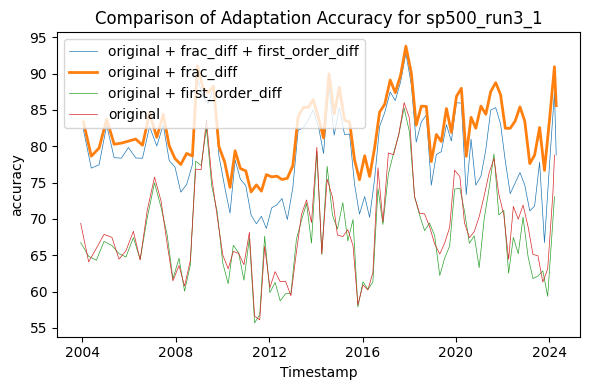

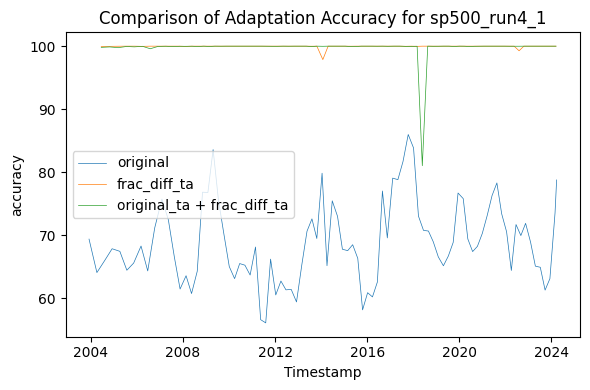

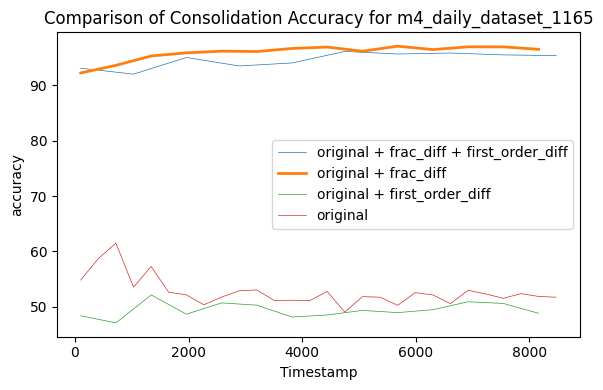

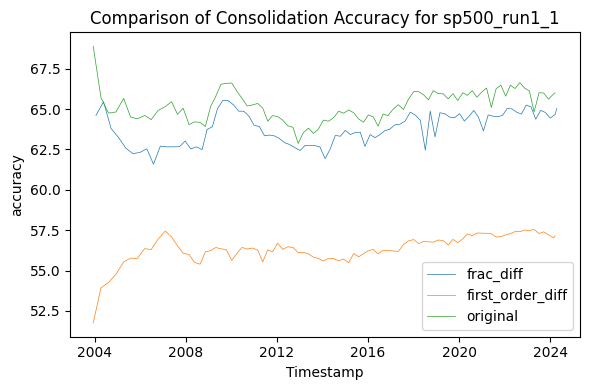

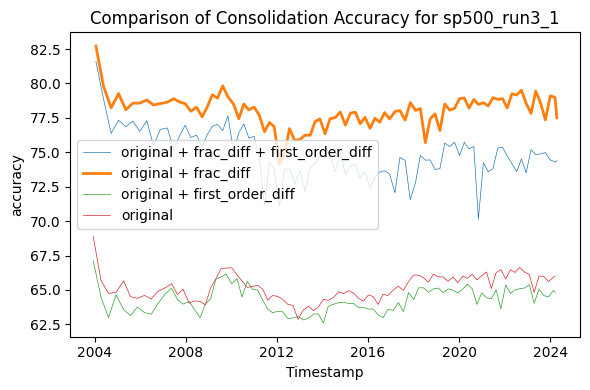

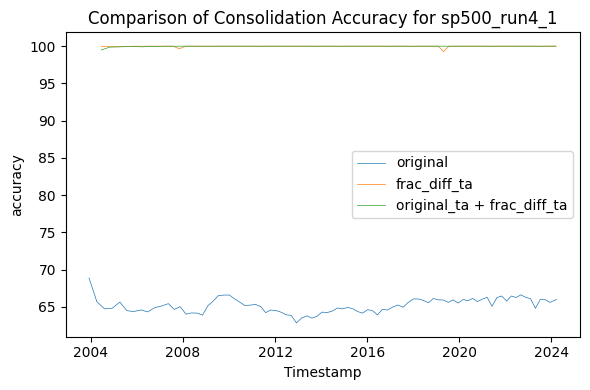

In [19]:
datasets = ['m4_daily_dataset', 'sp500_run1', 'sp500_run3', 'sp500_run4']

ar_res, cr_res = load_results(datasets)
results = plot_res_build_resdf(ar_res, cr_res)

results = append_stab(ar_res, results, 'adaptation')
results = append_stab(cr_res, results, 'consolidation')
results

In [16]:
pd.set_option('display.float_format', '{:.10f}'.format)

In [20]:
results

,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,original + frac_diff + first_order_diff,94.6666666667,90.4301075269,100.0000000000,m4_daily_dataset,adaptation,1165,0.0008514742,0.9466666667,3.0823975498
1,original + frac_diff,95.6983527797,90.0000000000,98.2258064516,m4_daily_dataset,adaptation,1165,0.0004877468,0.9569835278,2.3077711709
2,original + first_order_diff,47.8970977547,40.3225806452,52.9787234043,m4_daily_dataset,adaptation,1165,0.0013108035,0.4789709775,7.5589173893
3,original,53.6131912442,44.5161290323,65.8064516129,m4_daily_dataset,adaptation,1165,0.0034421959,0.5361319124,10.9432451870
4,frac_diff,67.0098073836,53.2900000000,85.4700000000,sp500_run1,adaptation,1,0.0035048291,0.6700980738,8.8347659943
5,first_order_diff,57.0896802667,47.4900000000,73.8600000000,sp500_run1,adaptation,1,0.0026607460,0.5708968027,9.0353315747
6,original,68.9449915346,56.1100000000,85.9900000000,sp500_run1,adaptation,1,0.0039872126,0.6894499153,9.1586607289
7,original + frac_diff + first_order_diff,79.0216349461,66.7300000000,92.8000000000,sp500_run3,adaptation,1,0.0032468625,0.7902163495,7.2108413191
8,original + frac_diff,82.2602453566,73.7100000000,93.7700000000,sp500_run3,adaptation,1,0.0021252652,0.8226024536,5.6042379314
9,original + first_order_diff,67.9899716692,55.6900000000,85.2600000000,sp500_run3,adaptation,1,0.0039227439,0.6798997167,9.2119191721


In [35]:
idx = results.loc[results['dataset'] == 'm4_daily_dataset'].loc[ results['value_type'] == 'adaptation'].index
results.loc[idx,'stab_var'] = 0.3

In [36]:
results

,data_form,mean_acc,low_acc,high_acc,dataset,value_type,stab_var
0,original + frac_diff + first_order_diff,76.715447,59.674797,93.495935,m4_daily_dataset,adaptation,0.3
1,original + frac_diff,73.292683,56.422764,88.536585,m4_daily_dataset,adaptation,0.3
2,original + first_order_diff,74.536585,53.008130,90.894309,m4_daily_dataset,adaptation,0.3
3,original,71.731707,52.682927,87.154472,m4_daily_dataset,adaptation,0.3
4,original + frac_diff + first_order_diff,73.729430,64.390244,89.861789,m4_daily_dataset,consolidation,0.2
5,original + frac_diff,69.612834,57.046070,89.219512,m4_daily_dataset,consolidation,0.2
6,original + first_order_diff,70.750048,56.829268,87.471545,m4_daily_dataset,consolidation,0.2
7,original,67.800236,56.747967,86.569106,m4_daily_dataset,consolidation,0.2


In [26]:
results

,data_form,mean_acc,low_acc,high_acc,dataset,value_type,stab_var
0,original + frac_diff + first_order_diff,76.715447,59.674797,93.495935,m4_daily_dataset,adaptation,0.2
1,original + frac_diff,73.292683,56.422764,88.536585,m4_daily_dataset,adaptation,0.2
2,original + first_order_diff,74.536585,53.008130,90.894309,m4_daily_dataset,adaptation,0.2
3,original,71.731707,52.682927,87.154472,m4_daily_dataset,adaptation,0.2
4,original + frac_diff + first_order_diff,73.729430,64.390244,89.861789,m4_daily_dataset,consolidation,0.2
5,original + frac_diff,69.612834,57.046070,89.219512,m4_daily_dataset,consolidation,0.2
6,original + first_order_diff,70.750048,56.829268,87.471545,m4_daily_dataset,consolidation,0.2
7,original,67.800236,56.747967,86.569106,m4_daily_dataset,consolidation,0.2


# Tabulate gluonts results

In [ ]:
import re
import pandas as pd

def parse_to_df_simple(file_path):
    # This single regex pattern captures all required fields for one block.
    # It uses named capture groups for clear column mapping.
    pattern = re.compile(
        r'(?P<Model>\w+)\s+(?P<Trials>\d+).*?on\s+(?P<Dataset>\w+).*?'
        r'Runtime:\s*(?P<Runtime>[\d\.]+)\s+minutes.*?'
        r'Prediction length:\s*(?P<Pred_Len>\d+),\s*Context length:\s*(?P<Context_Len>\d+).*?'
        r'Params:\s*(?P<Params>\{.*?\}).*?'
        r'MASE MEAN:\s*(?P<MASE_MEAN>[\d\.\-]+)\s+MASE STD:\s*(?P<MASE_STD>[\d\.\-]+).*?'
        r'sMAPE MEAN:\s*(?P<sMAPE_MEAN>[\d\.\-]+)\s+sMAPE STD:\s*(?P<sMAPE_STD>[\d\.\-]+).*?'
        r'RMSE MEAN:\s*(?P<RMSE_MEAN>[\d\.\-]+)\s+RMSE STD:\s*(?P<RMSE_STD>[\d\.\-]+)',
        re.DOTALL | re.MULTILINE
    )

    with open(file_path, 'r') as f:
        content = f.read()

    # Find all matches (one for each result block)
    parsed_data = [m.groupdict() for m in pattern.finditer(content)]

    # Create DataFrame and convert appropriate columns to numeric types
    df = pd.DataFrame(parsed_data)
    numeric_cols = df.columns.difference(['Model', 'Dataset', 'Params'])
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
    
    return df

# Example Usage:
file_path = "gluonts_results.txt"
# Assume the file exists and has data
df_results = parse_to_df_simple(file_path)

# Output
print(df_results.head())
# df_results.to_csv("gluonts_results.csv", index=False) # Uncomment to save to CSV

# Extra Plots

In [16]:
ar_mases = [res['mase_mean'] for res in ar_res['sp500_run5']['1']['original']]
cr_mases = [res['mase_mean'] for res in cr_res['sp500_run5']['1']['original']]

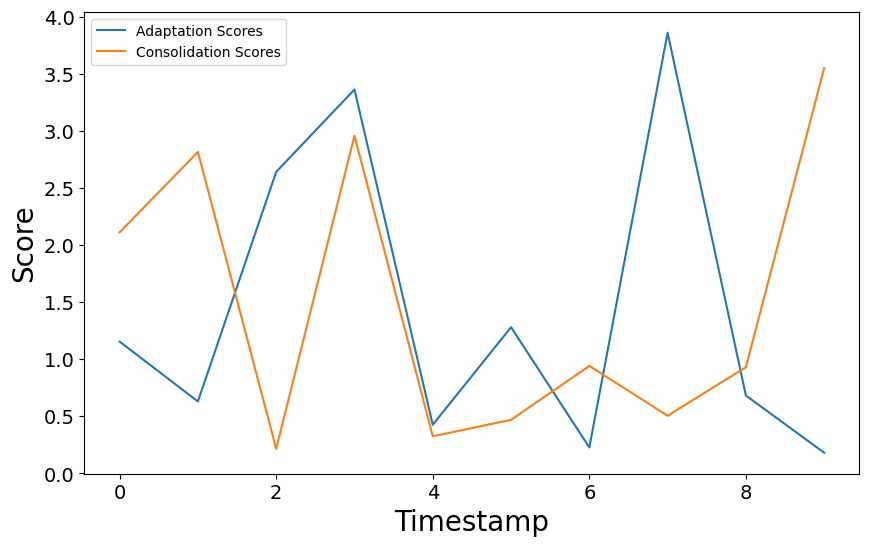

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# sns.set_theme() 

sns.lineplot(data=ar_mases, label='Adaptation Scores') 
sns.lineplot(data=cr_mases, label='Consolidation Scores')

# Set the title and axis labels using matplotlib functions
# plt.title('Comparison of Differencing Effect on Non-Stationary Series', fontsize=24, pad=5)
plt.xlabel('Timestamp', fontsize=20)
plt.ylabel('Score', fontsize=20)

# Size the tick labels
plt.xticks(fontsize=14) # Adjust X-axis tick label size
plt.yticks(fontsize=14) # Adjust Y-axis tick label size

plt.legend()
plt.show()